# Predicting High-Performance Social Posts (Binary) — Periospot

**Question:** Using only **pre-posting** signals, can we predict if a post will be a **High Performer**?  

**Decisions:** Threshold chosen empirically during EDA; Tree ensembles (RF/XGBoost) as main tuned family.  

**Anti-leakage:** No post-outcome columns (impressions/engagements/reach) in features.


In [126]:
# TODO: imports
import pandas as pd, numpy as np
from pathlib import Path
import sys
sys.path.append("..")  # or use the relative path to where 'src' is located
from src import features, labeling, evaluation, utils

# TODO: define paths
ROOT = Path("..").resolve().parent / "periospot_ml_social_media_performance"
RAW = ROOT / "data" / "raw"
ART = ROOT / "artifacts"
# HINT: ensure ART exists
ART.mkdir(parents=True, exist_ok=True)


## Load Data & Initial Checks

We load post-level data. We'll inspect columns, NA rates, and confirm which columns are "pre-posting" vs "post-outcome".


In [127]:
# Load raw post performance CSV
df = pd.read_csv(RAW / "post_performance.csv", low_memory=False)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nTotal columns: {len(df.columns)}")

# Show the TOP 30 columns with HIGHEST missing rates (we just saw these - mostly video/platform-specific)
print("\n=== TOP 80 HIGHEST MISSING RATES (Expected - Platform/Content Specific) ===")
print(df.isna().mean().sort_values(ascending=False).head(70))

# Now let's see the USEFUL columns (LOW missing rates)
print("\n=== COLUMNS WITH <10% MISSING (The Useful Ones!) ===")
low_missing = df.isna().mean().sort_values()
print(low_missing[low_missing < 0.10])
print("Total number of features:", len(df.columns))


Dataset shape: (8434, 67)
Date range: 1/1/2021 12:35 am to 9/9/2025 9:46 am

Total columns: 67

=== TOP 80 HIGHEST MISSING RATES (Expected - Platform/Content Specific) ===
Poll Votes                  1.000000
SproutLink Clicks           1.000000
Hashtag Video Views         1.000000
Organic Full Video Views    0.997629
Paid Partial Video Views    0.997629
                              ...   
Post ID                     0.000000
Profile                     0.000000
Sent by                     0.000000
Link                        0.000000
Date                        0.000000
Length: 67, dtype: float64

=== COLUMNS WITH <10% MISSING (The Useful Ones!) ===
Date            0.000000
Post ID         0.000000
Network         0.000000
Post Type       0.000000
Content Type    0.000000
Profile         0.000000
Sent by         0.000000
Link            0.000000
Post            0.027152
dtype: float64
Total number of features: 67


### Column Analysis: Pre-Posting vs Post-Outcome

Let's categorize columns to understand what we can safely use without leakage.


In [128]:
# Categorize columns by type
all_cols = df.columns.tolist()

# PRE-POSTING FEATURES (Safe to use - known before publishing)
pre_posting_candidates = [
    'Date',           # When posted (time features)
    'Network',        # Which platform (X, Instagram, etc.)
    'Post Type',      # Type of post (photo, video, link, etc.)
    'Content Type',   # Content category
    'Profile',        # Which account posted
    'Post',           # Caption text (for text features: length, hashtags, etc.)
    'Permalink',      # URL (might extract domain info)
]

# POST-OUTCOME METRICS (LEAKAGE - these are results, not predictors!)
post_outcome_keywords = [
    'impression', 'reach', 'engagement', 'click', 'like', 'comment', 
    'share', 'save', 'view', 'follower', 'reaction', 'rate', 
    'video', 'watch', 'subscriber', 'playlist', 'card', 'annotation',
    'vote', 'sent', 'received'
]

# Identify columns
pre_posting_cols = [c for c in all_cols if any(p.lower() in c.lower() for p in ['date', 'network', 'post type', 'content type', 'profile', 'post', 'permalink']) and not any(k in c.lower() for k in post_outcome_keywords)]
post_outcome_cols = [c for c in all_cols if any(k in c.lower() for k in post_outcome_keywords)]
other_cols = [c for c in all_cols if c not in pre_posting_cols and c not in post_outcome_cols]

print("="*80)
print("✅ PRE-POSTING FEATURES (Safe to use):")
print("="*80)
for col in pre_posting_cols:
    print(f"  - {col} (NA: {df[col].isna().mean()*100:.1f}%)")

print("\n" + "="*80)
print("❌ POST-OUTCOME METRICS (Leakage - DO NOT use as predictors):")
print("="*80)
for col in post_outcome_cols:  # Show first 20
    print(f"  - {col} (NA: {df[col].isna().mean()*100:.1f}%)")


print("\n" + "="*80)
print("🤔 OTHER COLUMNS (Review these):")
print("="*80)
for col in other_cols:
    print(f"  - {col} (NA: {df[col].isna().mean()*100:.1f}%)")


✅ PRE-POSTING FEATURES (Safe to use):
  - Date (NA: 0.0%)
  - Post ID (NA: 0.0%)
  - Network (NA: 0.0%)
  - Post Type (NA: 0.0%)
  - Content Type (NA: 0.0%)
  - Profile (NA: 0.0%)
  - Post (NA: 2.7%)

❌ POST-OUTCOME METRICS (Leakage - DO NOT use as predictors):
  - Sent by (NA: 0.0%)
  - Impressions (NA: 46.6%)
  - Organic Impressions (NA: 57.2%)
  - Paid Impressions (NA: 99.0%)
  - Reach (NA: 93.2%)
  - Organic Reach (NA: 93.7%)
  - Paid Reach (NA: 99.0%)
  - Potential Reach (NA: 52.5%)
  - Engagement Rate (per Impression) (NA: 46.6%)
  - Engagements (NA: 44.0%)
  - Reactions (NA: 48.4%)
  - Likes (NA: 48.4%)
  - Dislikes (NA: 99.6%)
  - Love Reactions (NA: 99.0%)
  - Haha Reactions (NA: 99.0%)
  - Wow Reactions (NA: 99.0%)
  - Sad Reactions (NA: 99.0%)
  - Angry Reactions (NA: 99.0%)
  - Comments (NA: 44.0%)
  - Shares (NA: 46.2%)
  - Saves (NA: 99.1%)
  - Post Link Clicks (NA: 93.8%)
  - SproutLink Clicks (NA: 100.0%)
  - Other Post Clicks (NA: 62.4%)
  - Post Clicks (All) (NA: 62.6

In [129]:
legit_columns = ["Date", "Network", "Post Type", "Post", "Profile", "Content Type"]

nan_values_legit = df[legit_columns].isna().sum()/len(df) * 100 
print(nan_values_legit)

Date            0.0000
Network         0.0000
Post Type       0.0000
Post            2.7152
Profile         0.0000
Content Type    0.0000
dtype: float64


In [130]:
# Check: Which posts are missing captions?
missing_post = df[df['Post'].isna()]
print(f"Posts missing caption: {len(missing_post)}")
print(missing_post[['Date', 'Network', 'Post Type', 'Content Type']].value_counts())

Posts missing caption: 229
Date                Network    Post Type  Content Type
2/23/2025 7:33 am   Instagram  Story      Photo           5
                                          Video           4
12/20/2024 6:07 pm  Instagram  Story      Photo           2
12/2/2024 9:00 am   Instagram  Story      Photo           2
11/15/2024 2:48 pm  Instagram  Story      Photo           2
                                                         ..
12/27/2024 6:57 am  Instagram  Story      Photo           1
12/27/2024 7:19 pm  Instagram  Story      Photo           1
12/28/2024 9:00 pm  Instagram  Story      Photo           1
12/28/2024 9:18 pm  Instagram  Story      Photo           1
9/9/2025 10:02 am   Instagram  Story      Video           1
Name: count, Length: 219, dtype: int64


In [131]:
# 1. How many posts are missing captions?
missing_caption = df[df['Post'].isna()]
print(f"Missing captions: {len(missing_caption)} ({len(missing_caption)/len(df)*100:.2f}%)")

# 2. Is it related to Post Type?
print("\nMissing captions by Post Type:")
print(missing_caption['Post Type'].value_counts())

# 3. Is it related to Network?
print("\nMissing captions by Network:")
print(missing_caption['Network'].value_counts())

# 4. Compare to posts WITH captions - any pattern?
print("\nAll posts by Post Type:")
print(df['Post Type'].value_counts())

Missing captions: 229 (2.72%)

Missing captions by Post Type:
Post Type
Story    170
Post      57
Quote      1
Reel       1
Name: count, dtype: int64

Missing captions by Network:
Network
Instagram    172
Threads       44
YouTube        6
Facebook       6
X              1
Name: count, dtype: int64

All posts by Post Type:
Post Type
'@Reply    3958
Post       3621
Quote       435
Story       376
Reel         43
Pin           1
Name: count, dtype: int64


## Define Target Variable

We'll use **Engagement Rate (per Impression)** as our continuous outcome variable to explore. 

This is a POST-OUTCOME metric (it's what we're trying to predict), so it's the TARGET, not a predictor.

We'll examine its distribution, detect outliers, and decide how to binarize later.


In [132]:
# Verify the target column exists and explore its distribution
target_col = "Engagement Rate (per Impression)"
assert target_col in df.columns, f"Column '{target_col}' not found!"
df[target_col] = df[target_col].str.strip("%")
df[target_col] = df[target_col].astype(float)

# Verify the conversion worked
print(f"Target column dtype: {df[target_col].dtype}")
print(f"Sample values after conversion:")
print(df[target_col].head(10))
print(f"\nAny conversion errors (NaN introduced)?")
print(f"NaN count: {df[target_col].isna().sum()}")


print("="*80)
print("TARGET VARIABLE ANALYSIS")
print("="*80)
print(f"\nTarget: {target_col}")
print(f"\nMissing rate: {df[target_col].isna().mean()*100:.2f}%")
print(f"\nBasic statistics:")
print(df[target_col].describe())

print(f"\nPercentiles:")
for p in [50, 75, 80, 85, 90, 95, 99]:
    val = df[target_col].quantile(p/100)
    print(f"  {p}th percentile: {val:.4f} ({100-p}% are above this = potential 'High Performers')")

# Show a few example rows with the pre-posting features
print("\n" + "="*80)
print("EXAMPLE ROWS (Pre-Posting Features + Target)")
print("="*80)
display_cols = ['Date', 'Network', 'Post Type', 'Content Type', 'Profile', target_col]
available_display = [c for c in display_cols if c in df.columns]
print(df[available_display].head(10))


Target column dtype: float64
Sample values after conversion:
0     1.68
1    13.20
2      NaN
3     2.43
4     2.04
5      NaN
6     5.97
7      NaN
8      NaN
9      NaN
Name: Engagement Rate (per Impression), dtype: float64

Any conversion errors (NaN introduced)?
NaN count: 3933
TARGET VARIABLE ANALYSIS

Target: Engagement Rate (per Impression)

Missing rate: 46.63%

Basic statistics:
count    4501.000000
mean        4.514168
std         8.025959
min         0.000000
25%         0.000000
50%         2.160000
75%         5.410000
max       200.000000
Name: Engagement Rate (per Impression), dtype: float64

Percentiles:
  50th percentile: 2.1600 (50% are above this = potential 'High Performers')
  75th percentile: 5.4100 (25% are above this = potential 'High Performers')
  80th percentile: 6.6700 (20% are above this = potential 'High Performers')
  85th percentile: 8.9600 (15% are above this = potential 'High Performers')
  90th percentile: 11.5400 (10% are above this = potential 'High

In [133]:
# 1. Which rows have the target?
has_target = df[target_col].notna()
print(f"Rows WITH target: {has_target.sum()} ({has_target.sum()/len(df)*100:.1f}%)")
print(f"Rows WITHOUT target: {(~has_target).sum()} ({(~has_target).sum()/len(df)*100:.1f}%)")

# 2. Is it related to Network?
print("\nTarget availability by Network:")
print(df.groupby('Network')[target_col].apply(lambda x: x.notna().sum() / len(x) * 100))

# 3. Is it related to Post Type?
print("\nTarget availability by Post Type:")
print(df.groupby('Post Type')[target_col].apply(lambda x: x.notna().sum() / len(x) * 100))

# 4. Is it related to Date? (Maybe older posts don't have this metric?)
df['Year'] = pd.to_datetime(df['Date']).dt.year
print("\nTarget availability by Year:")
print(df.groupby('Year')[target_col].apply(lambda x: x.notna().sum() / len(x) * 100))

Rows WITH target: 4501 (53.4%)
Rows WITHOUT target: 3933 (46.6%)

Target availability by Network:
Network
Facebook     100.000000
Instagram     78.359511
LinkedIn      10.666667
Pinterest      0.000000
Threads       99.765533
TikTok       100.000000
X             45.253211
YouTube        0.000000
Name: Engagement Rate (per Impression), dtype: float64

Target availability by Post Type:
Post Type
'@Reply    49.949469
Pin         0.000000
Post       54.681027
Quote      29.655172
Reel       93.023256
Story      99.734043
Name: Engagement Rate (per Impression), dtype: float64


/var/folders/cd/2c6x3jgj47j_fwl7231ts7m00000gn/T/ipykernel_41894/3603389667.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Year'] = pd.to_datetime(df['Date']).dt.year



Target availability by Year:
Year
2020     0.342466
2021     0.070249
2022     1.809955
2023    35.222672
2024    96.007046
2025    97.846045
Name: Engagement Rate (per Impression), dtype: float64


In [142]:
# How much data do you have in 2024-2025?
df_2024_2025 = df[df['Year'].isin([2024, 2025])]
print(f"2024-2025 rows: {len(df_2024_2025)}")
print(f"Percentage of total: {len(df_2024_2025)/len(df)*100:.1f}%")

# How many posts per network in 2024-2025?
print("\nPosts per Network (2024-2025):")
print(df_2024_2025['Network'].value_counts())

print("\nNan values:")
print(df_2024_2025.isna().sum().head(20))

2024-2025 rows: 4535
Percentage of total: 53.8%

Posts per Network (2024-2025):
Network
X            3021
Threads       853
Instagram     439
Facebook       87
LinkedIn       75
TikTok         36
YouTube        23
Pinterest       1
Name: count, dtype: int64

Nan values:
Date                                   0
Post ID                                0
Network                                0
Post Type                              0
Content Type                           0
Profile                                0
Sent by                                0
Link                                   0
Post                                 226
Linked Content                      2739
Impressions                          128
Organic Impressions                 1018
Paid Impressions                    4451
Reach                               3974
Organic Reach                       4013
Paid Reach                          4451
Potential Reach                     2500
Engagement Rate (per Impression)

In [143]:
df_clean = df[(df['Year'].isin([2024, 2025])) & (df[target_col].notna())].copy()
df_clean['Date'] = pd.to_datetime(df_clean['Date'])

train = df_clean[df_clean['Year'] == 2024]
test = df_clean[df_clean['Year'] == 2025]

print(f"Training (2024): {len(train)} rows")
print(f"Test (2025): {len(test)} rows")
print(f"Train/Test ratio: {len(train)/(len(test)+0.001):.2f}")

Training (2024): 1635 rows
Test (2025): 2771 rows
Train/Test ratio: 0.59


/var/folders/cd/2c6x3jgj47j_fwl7231ts7m00000gn/T/ipykernel_41894/755170056.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['Date'] = pd.to_datetime(df_clean['Date'])


In [144]:
train = df_clean[(df_clean['Year'] == 2024) & (df_clean['Date'] < '2024-10-01')]
val = df_clean[(df_clean['Year'] == 2024) & (df_clean['Date'] >= '2024-10-01')]
test = df_clean[df_clean['Year'] == 2025]

print(f"Training (2024 Jan-Sep): {len(train)} rows")
print(f"Validation (2024 Oct-Dec): {len(val)} rows")
print(f"Test (2025): {len(test)} rows")

Training (2024 Jan-Sep): 669 rows
Validation (2024 Oct-Dec): 966 rows
Test (2025): 2771 rows


In [145]:
# Are they the same rows?
no_impressions = df_clean[df_clean['Impressions'].isna()]
no_eng_rate = df_clean[df_clean[target_col].isna()]

print(f"Rows missing Impressions: {len(no_impressions)}")
print(f"Rows missing Eng Rate: {len(no_eng_rate)}")
print(f"Overlap: {len(no_impressions[no_impressions.index.isin(no_eng_rate.index)])}")

Rows missing Impressions: 0
Rows missing Eng Rate: 0
Overlap: 0


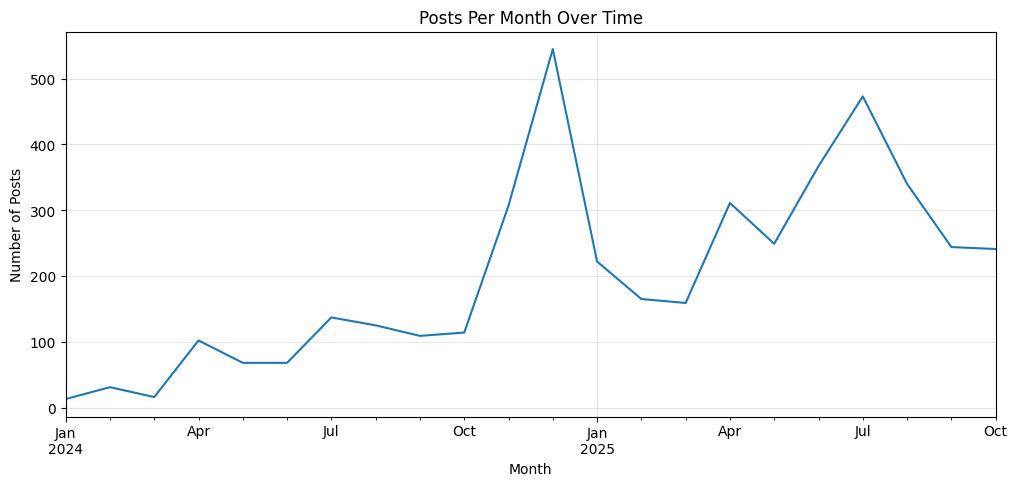


Posts per month:
YearMonth
2024-01     13
2024-02     31
2024-03     16
2024-04    102
2024-05     68
2024-06     68
2024-07    137
2024-08    125
2024-09    109
2024-10    114
2024-11    307
2024-12    545
2025-01    222
2025-02    165
2025-03    159
2025-04    311
2025-05    249
2025-06    367
2025-07    473
2025-08    340
2025-09    244
2025-10    241
Freq: M, dtype: int64


In [146]:
# Posts per month over time
df_clean['YearMonth'] = pd.to_datetime(df_clean['Date']).dt.to_period('M')
posts_per_month = df_clean.groupby('YearMonth').size()

import matplotlib.pyplot as plt
posts_per_month.plot(kind='line', figsize=(12, 5))
plt.title('Posts Per Month Over Time')
plt.ylabel('Number of Posts')
plt.xlabel('Month')
plt.grid(True, alpha=0.3)
plt.show()

print("\nPosts per month:")
print(posts_per_month)

In [147]:
# Use ALL 2024 for training (1,635 rows)
# Use part of 2025 for validation (say, Jan-Feb)
# Use rest of 2025 for test

train = df_clean[df_clean['Year'] == 2024]
val = df_clean[(df_clean['Year'] == 2025) & (df_clean['Date'] < '2025-03-01')]
test = df_clean[(df_clean['Year'] == 2025) & (df_clean['Date'] >= '2025-03-01')]

### Target Distribution Visualization

Let's visualize the distribution to choose a defensible threshold for "High Performer".


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Remove NaN values for plotting
target_clean = df[target_col].dropna()

# 1. Histogram
axes[0, 0].hist(target_clean, bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_title(f'Distribution of {target_col}', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel(target_col)
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(target_clean.quantile(0.80), color='red', linestyle='--', label='80th percentile')
axes[0, 0].axvline(target_clean.quantile(0.90), color='orange', linestyle='--', label='90th percentile')
axes[0, 0].legend()

# 2. Log-scale histogram (if needed for skewed data)
axes[0, 1].hist(target_clean, bins=100, edgecolor='black', alpha=0.7)
axes[0, 1].set_title(f'Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel(target_col)
axes[0, 1].set_ylabel('Frequency (log scale)')
axes[0, 1].set_yscale('log')
axes[0, 1].axvline(target_clean.quantile(0.80), color='red', linestyle='--', label='80th percentile')
axes[0, 1].axvline(target_clean.quantile(0.90), color='orange', linestyle='--', label='90th percentile')
axes[0, 1].legend()

# 3. Box plot
axes[1, 0].boxplot(target_clean, vert=False)
axes[1, 0].set_title('Box Plot (shows outliers)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel(target_col)

# 4. CDF (Cumulative Distribution)
sorted_vals = np.sort(target_clean)
cdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
axes[1, 1].plot(sorted_vals, cdf, linewidth=2)
axes[1, 1].axhline(0.80, color='red', linestyle='--', label='80th percentile cutoff')
axes[1, 1].axhline(0.90, color='orange', linestyle='--', label='90th percentile cutoff')
axes[1, 1].set_title('Cumulative Distribution Function', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel(target_col)
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("INTERPRETATION GUIDE")
print("="*80)
print("""
- Look at the distribution shape: Is it skewed? Are there outliers?
- Choose a percentile that separates 'High Performers' from 'Regular' posts
- Common choices:
  • 80th percentile = top 20% are "High Performers" (balanced)
  • 85th percentile = top 15% are "High Performers" (more selective)
  • 90th percentile = top 10% are "High Performers" (very selective)
  
Your choice should balance:
  1. Business value (catching enough high performers)
  2. Model difficulty (not too imbalanced)
  3. Interpretability (clear cutoff)
""")


## Identify Pre-Posting Features (No Leakage)

We will use **only features knowable before pressing publish**:

- Network, Post Type, Content Type, Profile (categorical)
- Posting timestamp → hour, weekday, month, season, year
- Caption text (Post): length, hashtag_count, mention_count, url_count
- Optional: rolling account-level activity windows (past 7/30/90 days aggregates) **computed from history prior to each post** (avoid peeking into future)

We explicitly **exclude**: impressions, reach, engagements, clicks, video views, saves, shares, etc. Any feature derived from those would leak.


In [ ]:
# TODO: parse date; keep only necessary columns at this stage
# - Parse 'Date' to datetime
# - Strip/normalize categorical text
# - Create a clean frame df_clean with a subset of columns we might use
# HINTS:
# df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# df['Network'] = df['Network'].str.strip()
# df['Post Type'] = df['Post Type'].str.strip()
# df['Content Type'] = df['Content Type'].str.strip()
# df['Profile'] = df['Profile'].str.strip()


## Feature Engineering (Pre-Posting Only)

We derive engineered features and keep an explicit list of predictors.


In [ ]:
# TODO: implement feature builders in src/features.py and call them here
# - time features: hour, weekday, month, is_weekend
# - text features from 'Post': char_len, word_len, hashtag_count (#...), mention_count (@...), url_count (http/https), emoji_count (optional)
# - categorical encodings: one-hot or ordinal for Network, Post Type, Content Type, Profile
# - OPTIONAL: lag features by Profile (e.g., past-30-day posting frequency) — careful with temporal leakage
# HINTS:
# df_feat = features.build_preposting_features(df)
# predictors = [...]  # set by your builder


## Train/Test Split Strategy (Temporal)

We simulate production by training on **past**, testing on **future**.  

Proposed split: Train on posts dated ≤ 2024-12-31; Test on posts dated ≥ 2025-01-01.


In [ ]:
# TODO: implement temporal split
# cutoff = pd.Timestamp("2025-01-01")
# train_idx = df_feat['Date'] < cutoff
# test_idx  = df_feat['Date'] >= cutoff
# X_train, X_test = df_feat.loc[train_idx, predictors], df_feat.loc[test_idx, predictors]
# y_cont_train = df.loc[train_idx, target_col]
# y_cont_test  = df.loc[test_idx, target_col]


## Choose Binary Threshold During EDA

From the **training set only**, pick a threshold rule:

- Percentile (e.g., top 20% engagement rate ⇒ label 1)
- Or a data-driven mixture/robust rule

We never use test data to define the threshold.


In [ ]:
# TODO: implement make_label_from_percentile in src/labeling.py and apply to y_cont_train
# pct = 0.80  # example; tune after inspecting distribution
# y_train = labeling.make_label_from_percentile(y_cont_train, pct=pct)
# y_test  = (y_cont_test >= y_cont_train.quantile(pct)).astype(int)  # use train threshold for test
# Check positivity rate


## Baseline Models (Sanity)

Establish simple baselines:

- Majority class
- Logistic Regression (quick baseline)

We expect low but non-zero performance.


In [ ]:
# TODO: majority baseline metrics; then fit LogisticRegression with simple preprocessing (OneHot for categoricals)
# HINT: use ColumnTransformer + Pipeline; score ROC-AUC, PR-AUC, F1


## Tree Ensembles (RF, XGBoost)

Main family: tree ensembles.  

We'll start with untuned models, then GridSearchCV on key hyperparameters.


In [ ]:
# TODO: fit RandomForestClassifier and XGBClassifier with default-ish params
# - Compute predicted probabilities on test
# - Evaluate ROC-AUC and PR-AUC


## Hyperparameter Tuning

Use GridSearchCV (or RandomizedSearchCV) with **Stratified K-Fold** on the training set.  

Keep the search space realistic (you have many rows).


In [ ]:
# TODO: GridSearchCV for RF and XGB
# HINTS:
# - RF: n_estimators, max_depth, min_samples_split, max_features
# - XGB: n_estimators, max_depth, learning_rate, subsample, colsample_bytree, reg_alpha, reg_lambda
# - Use scoring='average_precision' or 'roc_auc'
# Save best params to artifacts


## Threshold Tuning for Business Goal

Business objective: **maximize recall of High Performers** at an acceptable precision.  

We'll tune the decision threshold on validation folds or on the train set via cross-val predictions.


In [ ]:
# TODO: produce y_proba on the validation (or test) set, then scan thresholds
# Choose a threshold that achieves target recall (e.g., ≥ 0.75) with the highest precision
# evaluation.threshold_by_recall(...)
# Report threshold, precision, recall, F1


## Final Evaluation (Test)

Lock the threshold and evaluate on the test period.  

Report: ROC-AUC, PR-AUC, Precision, Recall, F1, Confusion Matrix. Plot ROC & PR curves.


In [ ]:
# TODO: compute and print metrics; plot ROC and PR curves; show confusion matrix
# Save figures to artifacts


## Feature Importance & Explainability

Compute feature importances (model-based) and optionally SHAP to interpret key drivers.  

Explain what matters: time-of-day? network? content type? caption length?


In [ ]:
# TODO: model.feature_importances_ (RF/XGB). Optional: SHAP summary plot.
# Save importance table to artifacts


## Robustness Checks

- Year-by-year performance stability  
- Per-network slices (X vs Instagram vs Threads)  
- Per-profile slices


In [ ]:
# TODO: compute metrics by Network and by Profile on test set
# HINT: loop over unique groups; filter and re-evaluate with the fixed threshold


## Conclusions

- What did we learn about drivers of high performance?
- Are results as expected?
- Business trade-offs for threshold choice (recall vs precision)
- Next steps: richer text features, topic modeling, uplift vs baseline scheduling, online learning


In [ ]:
# TODO: persist: best params JSON, chosen threshold, metrics JSON, importance CSVs
# HINT: use json.dump(...) and df.to_csv(...)
